# Import Libraries

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, f1_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import make_pipeline

In [3]:
data = pd.read_csv("../../../../../../Downloads/UKRiverData.csv")
print(len(data))

141431


In [4]:
weather = pd.read_csv("../../../../../../Downloads/archive.csv")
weather['time'] = pd.to_datetime(weather['time'])
len(weather)

253752

# Preprocessing

In [5]:
data = data.dropna(subset=['DO_MGL', 'NH4_N_MGL', 'PH', 'NO2_N_MGL'])

# Convert 'Date' and 'Time' columns to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Time'] = pd.to_datetime(data['Time'])

# Combine 'Date' and 'Time' columns into 'DateTime' column
data['DateTime'] = data['Date'] + pd.to_timedelta(data['Time'].dt.strftime('%H:%M:%S'))
data = data.rename(columns={'DateTime': 'time'})
data = data.drop_duplicates(subset=['time'])
data['time'] = data['time'].dt.round('H')
print(len(data))

# Remove 'Date' and 'Time' columns if no longer needed
data = data.drop(['Site_Code', 'Site_Status_21Oct2020', 'OBJECTID', 'Station_Name', 'RWB_ID_RBP2', 'FESOL1_UGL',
                  'P_SOL_MGL', 'SS_MGL','ZN_SOL_UGL', 'GlobalID','Primary_Basin', 'Depth', 'ALK_MGL', 'BOD_MGL', 
                  'COND_USCM', 'CUSOL1_MGL', 'CUSOL2_UGL', 'Date', 'Time'], axis=1)

# Combine the dataframs using merge function
weather['time'] = weather['time'].dt.tz_localize('UTC')
comb = pd.merge(data, weather, on=['time'], how='left')

# Convert our problem to a classification problem
comb['decreaseFeed'] = 1
comb.loc[comb['NH4_N_MGL'] <= 0.05, 'decreaseFeed'] = 0

# Smoothen the data
comb = comb.drop(comb[comb['NH4_N_MGL'] < 0].index)

90393


In [19]:
# Convert our problem to a classification problem
comb['decreaseFeed'] = 1
comb.loc[comb['NH4_N_MGL'] <= 0.15, 'decreaseFeed'] = 0

In [6]:
comb = comb.drop(comb[comb['NH4_N_MGL'] > 3].index)
comb = comb.drop(comb[comb['NH4_N_MGL'] < 0].index)
'''
# randomly remove rows
condition = comb['NH4_N_MGL'] < 0.2

# Randomly select and remove 3 rows that satisfy the condition
num_rows_to_remove = 30000
rows_to_remove = comb[condition].sample(n=num_rows_to_remove)
comb = comb[~comb.index.isin(rows_to_remove.index)]
'''

"\n# randomly remove rows\ncondition = comb['NH4_N_MGL'] < 0.2\n\n# Randomly select and remove 3 rows that satisfy the condition\nnum_rows_to_remove = 30000\nrows_to_remove = comb[condition].sample(n=num_rows_to_remove)\ncomb = comb[~comb.index.isin(rows_to_remove.index)]\n"

79850
10150


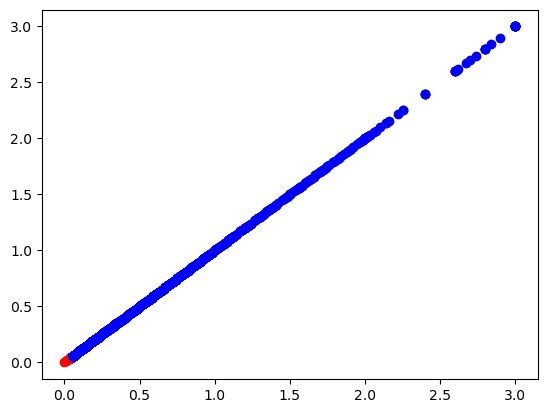

In [9]:
x = comb.sample(9000)
dec = x[x['decreaseFeed'] == 1]
print(len(dec) * 10)
man = x[x['decreaseFeed'] == 0]
print(len(man) * 10)
plt.plot(man['NH4_N_MGL'], man['NH4_N_MGL'], 'ro')
plt.plot(dec['NH4_N_MGL'], dec['NH4_N_MGL'], 'bo')
plt.show()


# Feature Selection

In [96]:
samp = comb.sample(10000)
X = samp[['DO_MGL','PH','temperature_2m (°C)', 'pressure_msl (hPa)', 'diffuse_radiation (W/m²)']].values
y = samp['decreaseFeed'].values
regressor = RandomForestClassifier(n_estimators=50)
regressor.fit(X, y)

print(regressor.feature_importances_)

[0.23896875 0.207959   0.18023651 0.19303237 0.17980338]


# Classification Methods

In [6]:
# split testset into training and tetsing
test = cis.copy(True)
X_train,X_test,y_train,y_test = train_test_split(test[['DO_MGL','PH','precipitation (mm)','pressure_msl (hPa)', 'direct_radiation (W/m²)']], 
        test['decreaseFeed'], test_size=0.2)

In [9]:
def stats(y_pred, y_test):
    # add F1 score, ROC AUC
    print("F1 Score: ", f1_score(y_test, y_pred))
    print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    tp = cm.data[0, 0]
    tn = cm.data[0, 1]
    fp = cm.data[1, 0]
    fn = cm.data[1, 1]

    print("Precision : ", tp/(tp + tn))
    print("Recall: ", tp/(tp + fp))
    print("Accuracy: ", (tp + fn)/(tp + tn + fp + fn))

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [13]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

F1 Score:  0.5734518844913054
ROC AUC Score:  0.5707071421576654
[[3563 2741]
 [2680 3644]]
Precision :  0.5651967005076142
Recall:  0.5707192055101714
Accuracy:  0.5707158694963573
Mean Absolute Error (MAE): 0.4292841305036427
Root Mean Squared Error (RMSE): 0.8094428822867059


In [14]:
print("------ Polynomial SVC Results ------")
clf = make_pipeline(preprocessing.RobustScaler(), NuSVC(kernel='rbf', gamma='auto', degree=3, nu=0.5))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

print("------ Exponential SVC Results ------")
clf = make_pipeline(preprocessing.QuantileTransformer(), SVC(kernel='poly', gamma='auto', degree=9))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ Polynomial SVC Results ------
F1 Score:  0.5700138352872642
ROC AUC Score:  0.5322510912421297
[[2809 3495]
 [2410 3914]]
Precision :  0.4455901015228426
Recall:  0.538225713738264
Accuracy:  0.5323883433639531
Mean Absolute Error (MAE): 0.46761165663604687
Root Mean Squared Error (RMSE): 0.8269349207180704
------ Exponential SVC Results ------
F1 Score:  0.6693760984182776
ROC AUC Score:  0.5225830732653304
[[ 514 5790]
 [ 230 6094]]
Precision :  0.08153553299492386
Recall:  0.6908602150537635
Accuracy:  0.5232815964523282
Mean Absolute Error (MAE): 0.47671840354767187
Root Mean Squared Error (RMSE): 0.8309319906542257


In [17]:
print("------ Boosting Results ------")
model = make_pipeline(preprocessing.QuantileTransformer(), GradientBoostingClassifier(learning_rate=0.01, max_depth=3, criterion='squared_error'))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

print("------ Bagging Results ------")
# import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
clf = make_pipeline(preprocessing.QuantileTransformer(), BaggingClassifier(n_jobs=5, base_estimator=DecisionTreeClassifier(), n_estimators=100))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)


print("------ Stacking Results ------")
neural = ('nn', make_pipeline(preprocessing.SplineTransformer(), MLPClassifier(hidden_layer_sizes=(16, 32), activation='relu', max_iter=200000)))
clf = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=24, criterion='entropy', max_features='sqrt')), 
    ('svm', SVC(kernel='rbf')),
    ('gb', GradientBoostingClassifier(max_depth=2))
    ])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ Boosting Results ------
F1 Score:  0.6149165236386331
ROC AUC Score:  0.6091002831048908
[[3751 2553]
 [2383 3941]]
Precision :  0.595019035532995
Recall:  0.6115096185197261
Accuracy:  0.6091225847323408
Mean Absolute Error (MAE): 0.3908774152676592
Root Mean Squared Error (RMSE): 0.7906970972523976
------ Bagging Results ------
F1 Score:  0.7867986798679868
ROC AUC Score:  0.7954410640955252
[[5276 1028]
 [1556 4768]]
Precision :  0.8369289340101523
Recall:  0.772248243559719
Accuracy:  0.7953753563509661
Mean Absolute Error (MAE): 0.2046246436490339
Root Mean Squared Error (RMSE): 0.6725730854285915
------ Stacking Results ------
F1 Score:  0.8112538419103159
ROC AUC Score:  0.8103364790324186
[[5086 1218]
 [1177 5147]]
Precision :  0.8067893401015228
Recall:  0.8120708925435095
Accuracy:  0.8103420969274627
Mean Absolute Error (MAE): 0.18965790307253722
Root Mean Squared Error (RMSE): 0.659922196528531


In [16]:
print("------ KNN Results ------")
from sklearn.neighbors import KNeighborsClassifier
k = 2 
knn = KNeighborsClassifier(n_neighbors=k)
# Train the kNN classifier
knn.fit(X_train, y_train)
# Make predictions on the test set
y_pred = knn.predict(X_test)
stats(y_pred, y_test)

print("------ Decision Tree Results ------")
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

print("------ Random Forest Results ------")
clf = RandomForestClassifier(max_depth=40, criterion='gini', max_features='log2')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ KNN Results ------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


F1 Score:  0.5824532900081235
ROC AUC Score:  0.6747247613635269
[[5648  656]
 [3456 2868]]
Precision :  0.8959390862944162
Recall:  0.6203866432337434
Accuracy:  0.6743744060817232
Mean Absolute Error (MAE): 0.32562559391827683
Root Mean Squared Error (RMSE): 0.7554046140487042
------ Decision Tree Results ------
F1 Score:  0.6988279259385086
ROC AUC Score:  0.7193043501992249
[[4968 1336]
 [2210 4114]]
Precision :  0.7880710659898477
Recall:  0.6921147952075787
Accuracy:  0.7191954387076338
Mean Absolute Error (MAE): 0.2808045612923662
Root Mean Squared Error (RMSE): 0.7279491437142798
------ Random Forest Results ------
F1 Score:  0.796165820088481
ROC AUC Score:  0.8030324511088207
[[5281 1023]
 [1465 4859]]
Precision :  0.8377220812182741
Recall:  0.7828342721612808
Accuracy:  0.8029775102945834
Mean Absolute Error (MAE): 0.19702248970541653
Root Mean Squared Error (RMSE): 0.6662373110880252


# Deep Learning

In [2]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        #'PH_DO', 'Pressure_DO', 'RH_DO', 'CloudCover_DO', 'Temp_DO','DiffuseRad_DO', 'Precip_DO', 'RH_PH', 'RH_Pressure'
        self.numeric_columns = ['PH_DO', 'Pressure_DO', 'RH_DO', 'CloudCover_DO']
        self.transformer = preprocessing.StandardScaler()
        transformed_data = self.transformer.fit_transform(dataframe[self.numeric_columns].values)
        dataframe[self.numeric_columns] = transformed_data
        self.data = dataframe.dropna(subset=['NH4_N_MGL']).reset_index(drop=True)
        

    def __len__(self):
        return len(self.data)
    
    def getInverseTransform(self, inputs):
        return self.quantile_transformer.inverse_transform(inputs)

    def __getitem__(self, idx):
        inputs = self.data[self.numeric_columns].iloc[idx].values.astype(np.float32)
        label = self.data['NH4_N_MGL'].iloc[idx].astype(np.float32)
        inputs = torch.tensor(inputs)
        label = torch.tensor(label)
        return inputs, label

Artifical Neural Network

In [28]:
ann = nn.Sequential(
    nn.Linear(4, 32),
    nn.CELU(),
    nn.Linear(32, 32),
    nn.CELU(),
    nn.Linear(32, 32),
    nn.CELU(),
    nn.Linear(32, 8),
    nn.CELU(),
    nn.Linear(8, 1),
    nn.Tanh()
)

Reccurrent Neural Network

In [5]:
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[-1, :]

model = nn.Sequential(
    nn.RNN(input_size=4, hidden_size=32, num_layers=5, batch_first=True, nonlinearity="relu"),
    extract_tensor(),
    nn.CELU(),
    nn.Linear(32, 1),
)

Long Short Term Memory (LSTM)

In [4]:
model = nn.Sequential(
    nn.LSTM(input_size=4, hidden_size=16, num_layers=7 ,dropout=0.15),
    extract_tensor(),
    nn.Linear(16, 1)
)

A mix of RNN and LSTM

In [63]:
model = nn.Sequential(
    nn.LSTM(input_size=3, hidden_size=8, num_layers=3 ,dropout=0.15),
    extract_tensor(),
    nn.Linear(8, 8),
    nn.CELU(),
    nn.RNN(input_size=8, hidden_size=16, num_layers=2, batch_first=True, nonlinearity="relu"),
    extract_tensor(),
    nn.Linear(16, 1)
)

In [29]:
loss_fn = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 12

test = ammData.copy(True)

# split testset into training and tetsing
trainset, testset = train_test_split(test, test_size=0.15)

dataset = MyDataset(trainset)
data_loader = DataLoader(dataset, drop_last=True, batch_size=1)

print(ann)
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()

    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = ann(inputs)
        
        labels = labels.view(outputs.shape)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step() 
        running_loss += abs(loss.item())

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): CELU(alpha=1.0)
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): CELU(alpha=1.0)
  (6): Linear(in_features=32, out_features=8, bias=True)
  (7): CELU(alpha=1.0)
  (8): Linear(in_features=8, out_features=1, bias=True)
  (9): Tanh()
)
Epoch 1, Training Loss: 0.0337
Epoch 2, Training Loss: 0.0337
Epoch 3, Training Loss: 0.0337
Epoch 4, Training Loss: 0.0337
Epoch 5, Training Loss: 0.0337
Epoch 6, Training Loss: 0.0337
Epoch 7, Training Loss: 0.0337
Epoch 8, Training Loss: 0.0337
Epoch 9, Training Loss: 0.0337
Epoch 10, Training Loss: 0.0337
Epoch 11, Training Loss: 0.0337
Epoch 12, Training Loss: 0.0337


In [35]:
y_test_all = []
y_pred_all = []

dataset = MyDataset(testset)
data_loader = DataLoader(dataset)

# Disable gradient calculation
with torch.no_grad():
    for inputs, label in data_loader:
        # Forward pass to get predictions
        y_pred = model(inputs.unsqueeze(1))
        '''
        if y_pred <= 0.5:
            y_pred_all.append(0)  # Append zero to the list
        else:
            y_pred_all.append(1)  # Append one to the list
        '''
        y_pred_all.append(y_pred)
        
        # Convert the predictions and targets to numpy arrays
        label_np = label.numpy()

        # Append batch results to the overall lists
        y_test_all.append(label_np)

# Concatenate the lists into a single array
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)

stats(y_pred_all, y_test_all)

R2 Score: -0.3809
Mean Absolute Error (MAE): 0.1175637516110554
Root Mean Squared Error (RMSE): 0.4731284721567694


# Code Interpreter Supported

In [26]:
cis = pd.read_csv("../datasets/upsampled_data.csv")
cis.columns

Index(['DO_MGL', 'NH4_N_MGL', 'PH', 'relativehumidity_2m (%)',
       'pressure_msl (hPa)', 'precipitation (mm)', 'cloudcover (%)',
       'direct_radiation (W/m²)', 'decreaseFeed'],
      dtype='object')

# Regression

In [6]:
from sklearn.metrics import r2_score

def stats(y_pred_all, y_test_all):
    # Calculate the R2 score
    r2 = r2_score(y_test_all, y_pred_all)

    print(f"R2 Score: {r2:.4f}")
    # Calculate MAE
    mae = mean_absolute_error(y_test_all, y_pred_all)

    # Calculate RMSE
    mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [31]:
comb.to_csv("../datasets/combined.csv", index=False)

In [12]:
# import missing libraries
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

ammData = pd.read_csv("../../../../../../Downloads/final_features_short.csv")

# split train and test
test = ammData.copy(True)
print(test.columns)
X_train,X_test,y_train,y_test = train_test_split(test[['PH_DO', 'Pressure_DO', 'RH_DO', 'CloudCover_DO']], test['NH4_N_MGL'], test_size=0.2)

Index(['PH_DO', 'Pressure_DO', 'RH_DO', 'CloudCover_DO', 'Temp_DO',
       'DiffuseRad_DO', 'Precip_DO', 'RH_PH', 'RH_Pressure', 'NH4_N_MGL'],
      dtype='object')


In [4]:
print("------------ Exponential SVR Results ------------")
clf_rbf_nusvm = make_pipeline(preprocessing.SplineTransformer(), NuSVR(kernel='rbf', shrinking=True, C=3.5))
clf_rbf_nusvm.fit(X_train, y_train)
y_pred = clf_rbf_nusvm.predict(X_test)
stats(y_pred, y_test)

print("------------ Exponential SVR Results ------------")
clf_rbf_svm = make_pipeline(preprocessing.MinMaxScaler(), SVR(kernel='rbf', shrinking=True, C=0.5))
clf_rbf_svm.fit(X_train[:len(X_train)//2], y_train[:len(X_train)//2])
clf_rbf_svm.fit(X_train[len(X_train)//2:], y_train[len(X_train)//2:])
y_pred = clf_rbf_svm.predict(X_test)
stats(y_pred, y_test)

print("------------ Polynomial SVR Results ------------")
clf_poly_nusvm = make_pipeline(preprocessing.QuantileTransformer(), NuSVR(kernel='poly', shrinking=False, C=4.5))
clf_poly_nusvm.fit(X_train, y_train)
y_pred = clf_poly_nusvm.predict(X_test)
stats(y_pred, y_test)

------------ Exponential SVR Results ------------


In [20]:
print("------------ Random Forest Results ------------")
rf_regressor = make_pipeline(preprocessing.MaxAbsScaler(), RandomForestRegressor(n_estimators=24, max_depth=20))
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
stats(y_pred, y_test)

print("------------ Poly Regression Results ------------")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# Initialize and fit the linear regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
# Predict the target variable for training and test sets
y_pred = poly_reg.predict(X_test_poly)
stats(y_pred, y_test)

print("------------ Decision Tree Results ------------")
from sklearn.tree import DecisionTreeRegressor
d_tree = make_pipeline(preprocessing.MinMaxScaler(), DecisionTreeRegressor(max_depth=24))
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)
stats(y_pred, y_test)

print("------------ XG Boost Results ------------")
from sklearn.ensemble import GradientBoostingRegressor
xg_boost = make_pipeline(preprocessing.QuantileTransformer(), GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error'))
xg_boost.fit(X_train, y_train)
y_pred = xg_boost.predict(X_test)
stats(y_pred, y_test)

------------ Random Forest Results ------------
R2 Score: -0.0279
Mean Absolute Error (MAE): 0.08687309743820493
Root Mean Squared Error (RMSE): 0.4340116137635543
------------ Poly Regression Results ------------
R2 Score: -1776154169.5491
Mean Absolute Error (MAE): 58.388607899896385
Root Mean Squared Error (RMSE): 88.48700823274972
------------ Decision Tree Results ------------
R2 Score: -0.8672
Mean Absolute Error (MAE): 0.10334033707407436
Root Mean Squared Error (RMSE): 0.5038548853485886
------------ XG Boost Results ------------
R2 Score: 0.0160
Mean Absolute Error (MAE): 0.0725476387299373
Root Mean Squared Error (RMSE): 0.42929697446271264


In [7]:
# Bagging
print("------ Bagging Results ------")
bagging = make_pipeline(preprocessing.StandardScaler(), BaggingRegressor(n_estimators=10))
bagging.fit(X_train, y_train)
y_pred_bagging = bagging.predict(X_test)
stats(y_pred_bagging, y_test)

# LinearRegression
print("------ LinearRegression Results ------")
linear_regression = make_pipeline(preprocessing.StandardScaler(), LinearRegression())
linear_regression.fit(X_train, y_train)
y_pred_lr = linear_regression.predict(X_test)
stats(y_pred_lr, y_test)

# Stacking
print("------ Stacking Results ------")
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

model = StackingRegressor(estimators=[
    ('svr', NuSVR(kernel='poly', shrinking=False, C=2.5)), 
    ('rf', RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=8)),
    ('bag', BaggingRegressor(n_jobs=5)),
    ('bst', GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')),
    ('n1', MLPRegressor(hidden_layer_sizes=(2,3), activation='relu')),
    ('n2', MLPRegressor(hidden_layer_sizes=(3,2), activation='tanh'))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)



------ Bagging Results ------
R2 Score: -0.0967
Mean Absolute Error (MAE): 0.0869412525937307
Root Mean Squared Error (RMSE): 0.42543690229319614
------ Stacking Results ------


In [19]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# Make predictions on the test data
y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.detach().numpy()
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred.reshape(-1, 1)})

ValueError: Per-column arrays must each be 1-dimensional

In [26]:
df = pd.DataFrame()
df['y_test'] = y_test
df['y_pred'] = rf_regressor.predict(X_test)

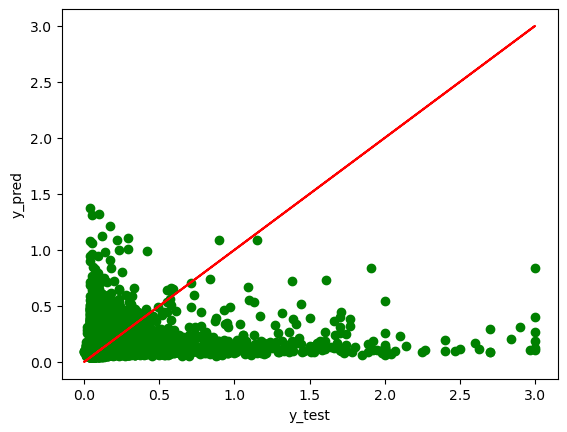

In [27]:
# plot df['y_test'] vs df['y_pred']
plt.plot(df['y_test'], df['y_pred'], 'go')
plt.plot(df['y_test'], df['y_test'], 'r')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()